In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  with open('/content/drive/MyDrive/ML/laptop_price_predictor/' + fn, 'wb') as f:
    f.write(uploaded[fn])

Saving laptop_data.csv to laptop_data.csv
User uploaded file "laptop_data.csv" with length 180028 bytes


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import dump

In [3]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/ML/laptop_price_predictor/laptop_data.csv')

In [4]:
# Display the first few rows and basic information about the dataset
print("First few rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

First few rows of the dataset:
   Unnamed: 0 Company   TypeName  Inches                    ScreenResolution  \
0           0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1           1   Apple  Ultrabook    13.3                            1440x900   
2           2      HP   Notebook    15.6                   Full HD 1920x1080   
3           3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4           4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu   Ram               Memory  \
0        Intel Core i5 2.3GHz   8GB            128GB SSD   
1        Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3        Intel Core i7 2.7GHz  16GB            512GB SSD   
4        Intel Core i5 3.1GHz   8GB            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS  1.37kg   856.544198  
1  

In [5]:
# Rows of the Dataset
df.columns

Index(['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution',
       'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype='object')

In [6]:
# Data Preprocessing

In [7]:
print("\nStep 1: Removing unnecessary columns")
df = df.drop(['Unnamed: 0'], axis=1)
print("Dropped 'Unnamed: 0' column")


Step 1: Removing unnecessary columns
Dropped 'Unnamed: 0' column


In [8]:
# Step 2: Convert 'Ram' to numeric
print("\nStep 2: Converting 'Ram' to numeric")
df['Ram'] = df['Ram'].str.replace('GB', '').astype('int32')
print("'Ram' column converted to integer")


Step 2: Converting 'Ram' to numeric
'Ram' column converted to integer


In [9]:
# Step 3: Convert 'Weight' to numeric
print("\nStep 3: Converting 'Weight' to numeric")
df['Weight'] = df['Weight'].str.replace('kg', '').astype('float32')
print("'Weight' column converted to float")


Step 3: Converting 'Weight' to numeric
'Weight' column converted to float


In [10]:
# Step 4: Process Screen Resolution
print("\nStep 4: Processing Screen Resolution")
df['ScreenResolution'] = df['ScreenResolution'].str.replace('"', '')
df[['X_res', 'Y_res']] = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)').astype(int)
df['PPI'] = ((df['X_res']**2 + df['Y_res']**2)**0.5 / df['Inches']).astype('float')
print("Extracted 'X_res', 'Y_res', and calculated 'PPI'")


Step 4: Processing Screen Resolution
Extracted 'X_res', 'Y_res', and calculated 'PPI'


In [11]:
# Step 5: Process TouchScreen
print("\nStep 5: Processing TouchScreen")
df['TouchScreen'] = df['ScreenResolution'].str.contains('Touch').astype(int)
print("Created 'TouchScreen' feature")


Step 5: Processing TouchScreen
Created 'TouchScreen' feature


In [12]:
# Process IPS
df['IPS'] = df['ScreenResolution'].str.contains('IPS').astype(int)

In [13]:
# Step 6: Process IPS
print("\nStep 6: Processing IPS")
df['IPS'] = df['ScreenResolution'].str.contains('IPS').astype(int)
print("Created 'IPS' feature")


Step 6: Processing IPS
Created 'IPS' feature


In [14]:
# Step 7: Process CPU
print("\nStep 7: Processing CPU")
df['CPU_brand'] = df['Cpu'].apply(lambda x: ' '.join(x.split()[:3]))

def processortype(text):
    if text in ['Intel Core i7', 'Intel Core i5', 'Intel Core i3']:
        return text
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        else:
            return 'AMD Processor'

df['CPU_brand'] = df['CPU_brand'].apply(processortype)

print(df['CPU_brand'].value_counts())
print("Extracted 'CPU_brand' from 'Cpu' column")


Step 7: Processing CPU
CPU_brand
Intel Core i7            527
Intel Core i5            423
Other Intel Processor    154
Intel Core i3            136
AMD Processor             63
Name: count, dtype: int64
Extracted 'CPU_brand' from 'Cpu' column


In [15]:
# Step 8: Process Memory
print("\nStep 8: Processing Memory")
def parse_storage(storage_string):
    storage_string = storage_string.replace('GB', '').replace('TB', '000').replace('.0', '')
    parts = storage_string.split('+')
    hdd, ssd = 0, 0

    for part in parts:
        part = part.strip()
        value = int(''.join(filter(str.isdigit, part)))
        if 'HDD' in part:
            hdd += value
        elif 'SSD' in part or 'Flash Storage' in part:
            ssd += value
        elif 'Hybrid' in part:
            # For Hybrid, we'll keep it in HDD as it's typically mostly HDD
            hdd += value
        else:
            # If no type is specified, assume it's SSD (common for newer laptops)
            ssd += value

    return hdd, ssd

# Apply the parsing function to the Memory column
df['HDD'], df['SSD'] = zip(*df['Memory'].apply(parse_storage))

print("Extracted 'HDD' and 'SSD' storage information")


Step 8: Processing Memory
Extracted 'HDD' and 'SSD' storage information


In [16]:
#  Step 9: Process GPU
print("\nStep 9: Processing GPU")
df['GPU_brand'] = df['Gpu'].apply(lambda x: x.split()[0])
print("Extracted 'GPU_brand' from 'Gpu' column")


Step 9: Processing GPU
Extracted 'GPU_brand' from 'Gpu' column


In [17]:
# Step 10: Simplify Operating System categories
print("\nStep 10: Simplifying Operating System categories")
def simplify_os(os):
    if 'Windows' in os:
        return 'Windows'
    elif 'Mac' in os:
        return 'Mac'
    else:
        return 'Other'

df['OpSys'] = df['OpSys'].apply(simplify_os)
print("Simplified 'OpSys' categories")


Step 10: Simplifying Operating System categories
Simplified 'OpSys' categories


In [18]:
# Step 11: Log transform the Price
print("\nStep 11: Log transforming the Price")
df['log_price'] = np.log(df['Price'])
print("Applied log transformation to 'Price'")


Step 11: Log transforming the Price
Applied log transformation to 'Price'


In [19]:
# Drop unnecessary columns
df = df.drop(['ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'Inches', 'X_res', 'Y_res'], axis=1)

In [20]:
# Exploratory Data Analysis (EDA)
print("\nExploratory Data Analysis (EDA)")


Exploratory Data Analysis (EDA)


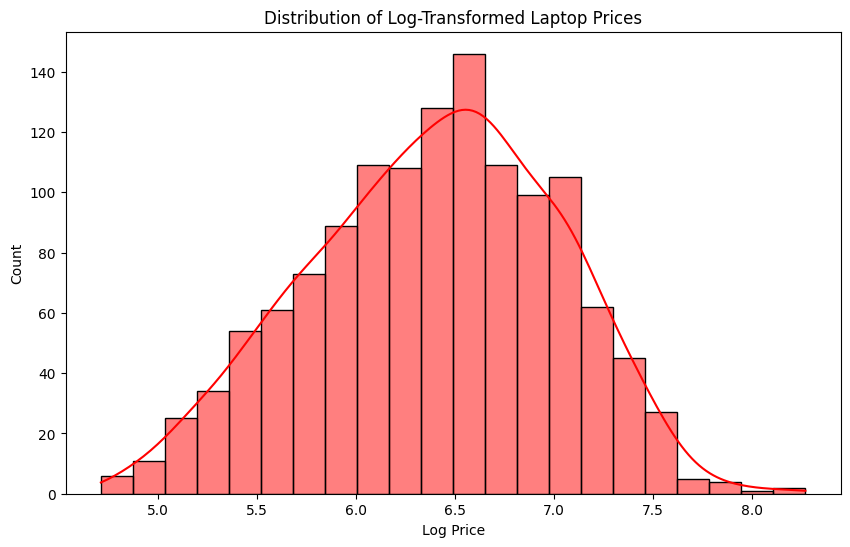

This plot shows the distribution of log-transformed prices, which appears more normal than raw prices.


In [21]:
# Distribution of log-transformed price
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price'], kde=True, color='red')
plt.title('Distribution of Log-Transformed Laptop Prices')
plt.xlabel('Log Price')
plt.show()
print("This plot shows the distribution of log-transformed prices, which appears more normal than raw prices.")

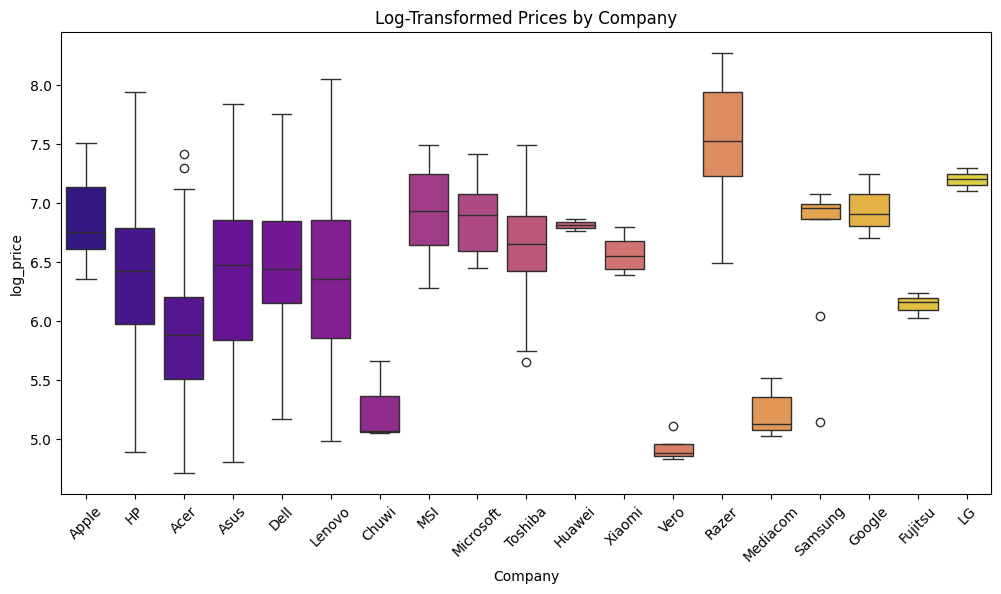

This boxplot shows price distributions for each company, helping identify potential price differences between brands.


In [22]:
# Boxplot of prices by company
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company', y='log_price', hue='Company', data=df, palette='plasma', legend=False)
plt.title('Log-Transformed Prices by Company')
plt.xticks(rotation=45)
plt.show()
print("This boxplot shows price distributions for each company, helping identify potential price differences between brands.")

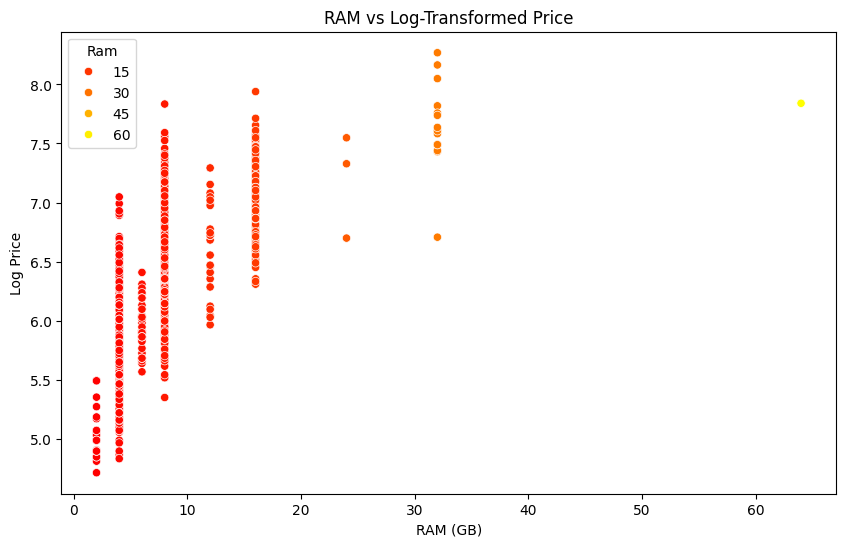

This scatter plot visualizes the relationship between RAM and price, showing a general trend of higher prices for more RAM.


In [23]:
# Scatter plot of RAM vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ram', y='log_price', hue='Ram', data=df, palette='autumn')
plt.title('RAM vs Log-Transformed Price')
plt.xlabel('RAM (GB)')
plt.ylabel('Log Price')
plt.show()
print("This scatter plot visualizes the relationship between RAM and price, showing a general trend of higher prices for more RAM.")

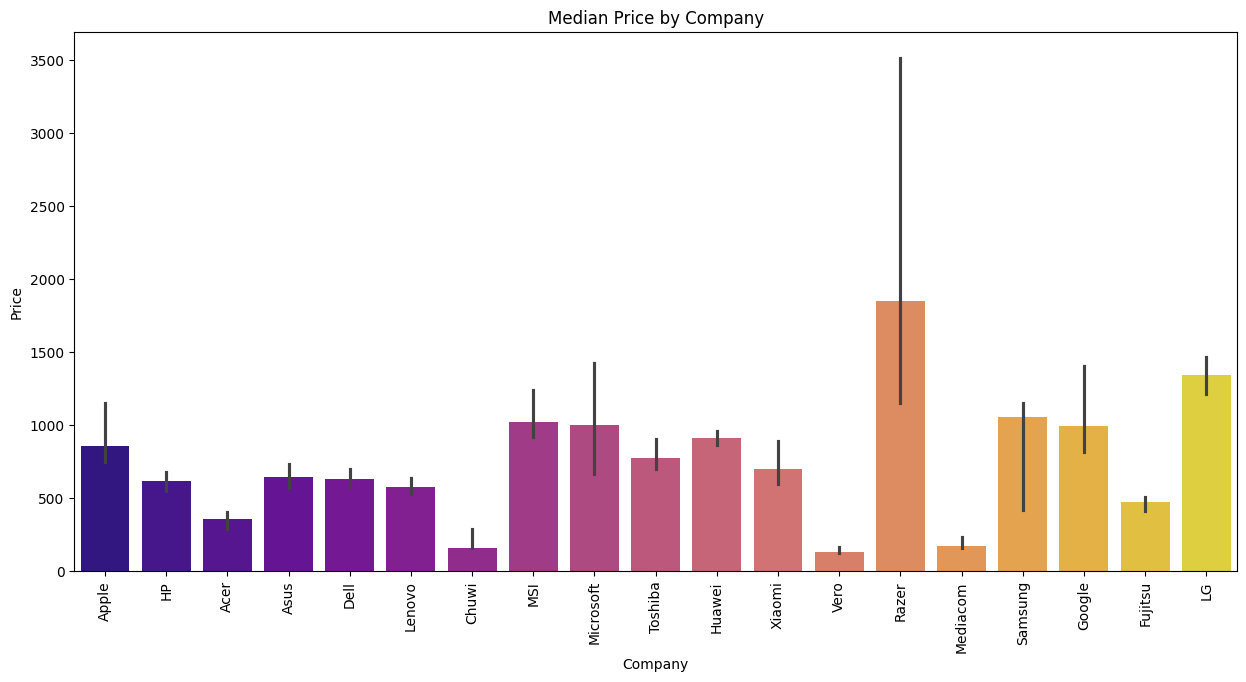

In [24]:
# Bar plot for average price by company
plt.figure(figsize=(15, 7))
sns.barplot(x='Company', y='Price', hue='Company', data=df, estimator=np.median, palette='plasma', legend=False)
plt.title('Median Price by Company')
plt.xticks(rotation='vertical')
plt.show()

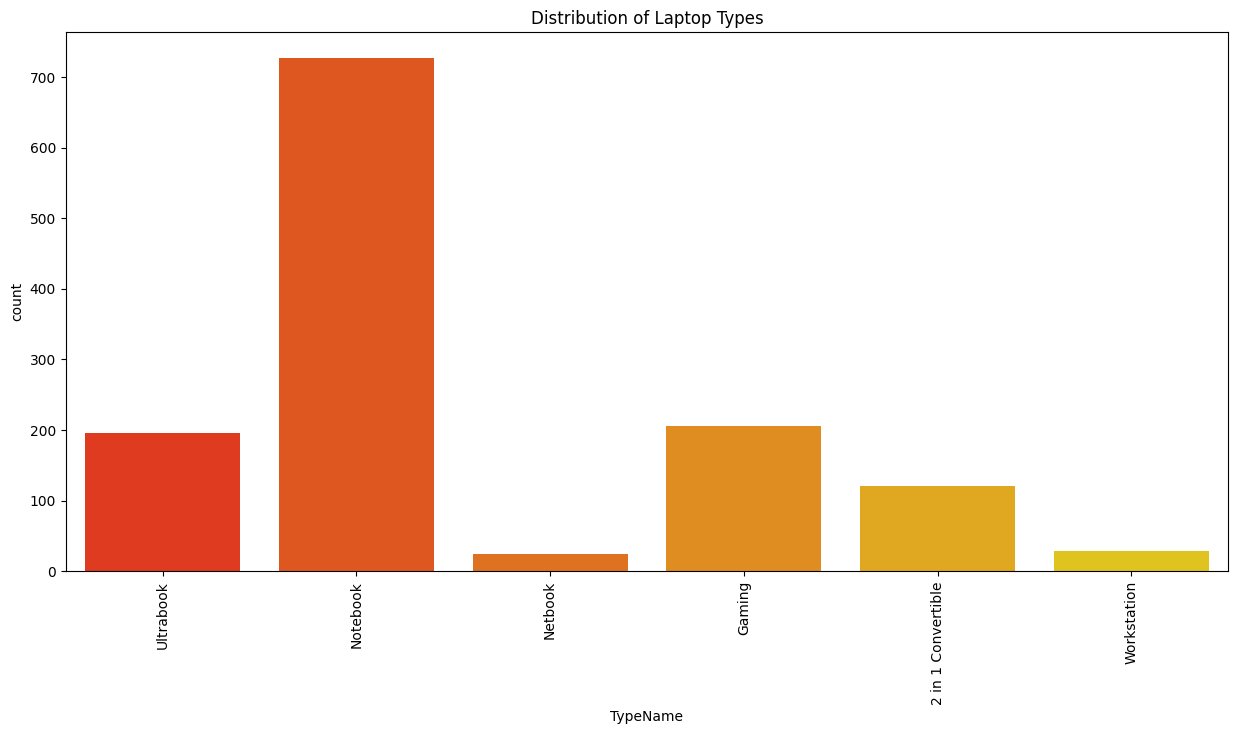

In [25]:
# Count plot for laptop types
plt.figure(figsize=(15, 7))
sns.countplot(x='TypeName', hue='TypeName', data=df, palette='autumn', legend=False)
plt.title('Distribution of Laptop Types')
plt.xticks(rotation='vertical')
plt.show()

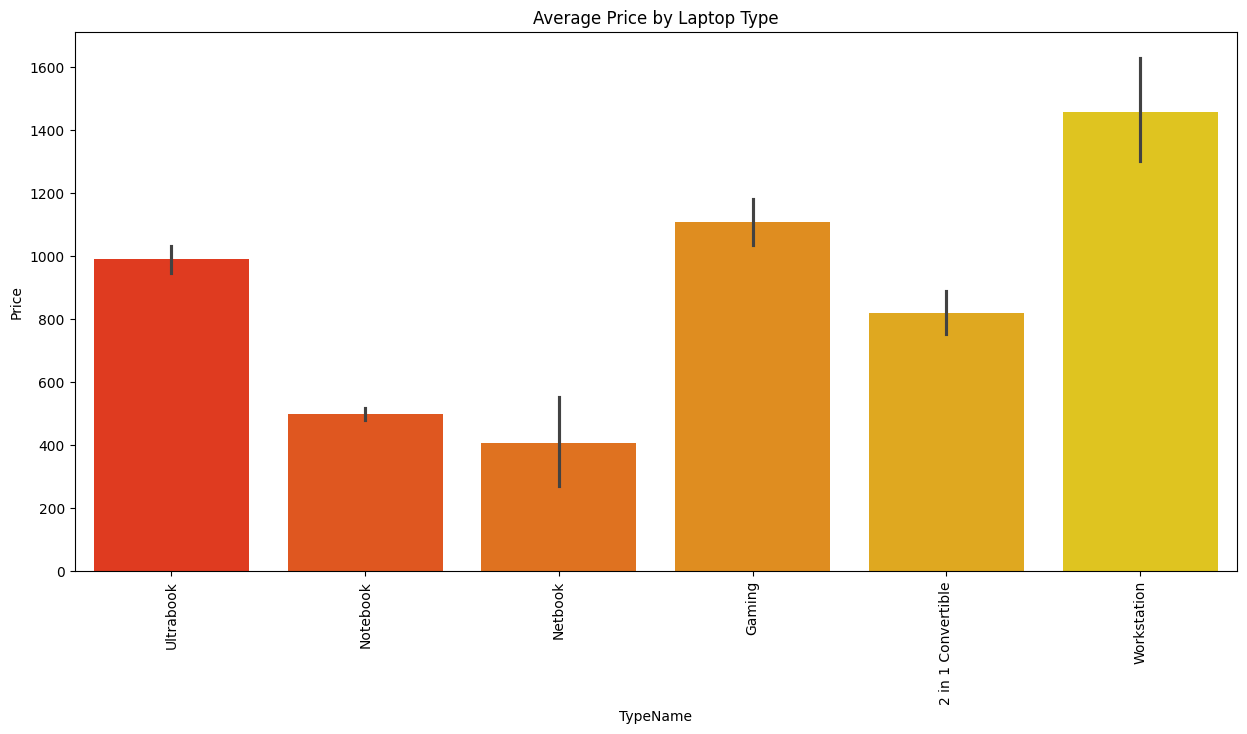

In [26]:
# Bar plot for average price by laptop type
plt.figure(figsize=(15, 7))
sns.barplot(x='TypeName', y='Price', hue='TypeName', data=df, palette='autumn', legend=False)
plt.title('Average Price by Laptop Type')
plt.xticks(rotation='vertical')
plt.show()

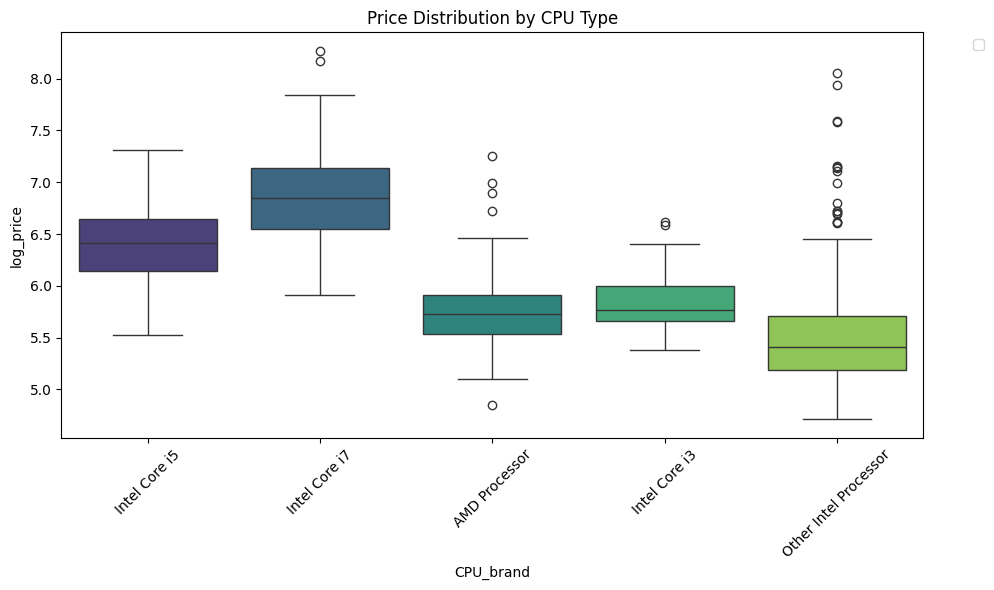

This boxplot shows how prices vary across different CPU types and laptop categories.


In [27]:
# Price vs CPU name
plt.figure(figsize=(10, 6))
sns.boxplot(x='CPU_brand', y='log_price', hue='CPU_brand', data=df, palette='viridis')
plt.title('Price Distribution by CPU Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("This boxplot shows how prices vary across different CPU types and laptop categories.")

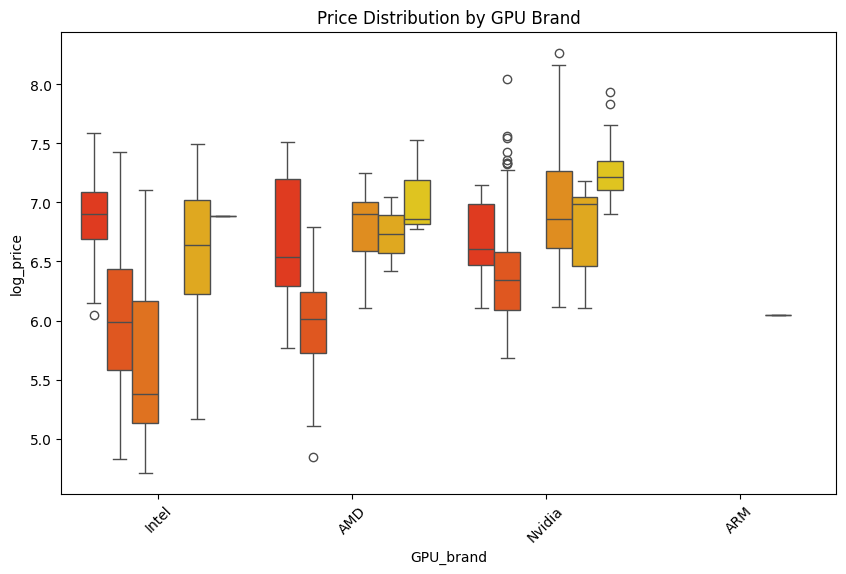

This boxplot illustrates price variations across different GPU brands.


In [28]:
# Price vs GPU brand
plt.figure(figsize=(10, 6))
sns.boxplot(x='GPU_brand', y='log_price', hue='TypeName', data=df, palette='autumn', legend=False)
plt.title('Price Distribution by GPU Brand')
plt.xticks(rotation=45)
plt.show()
print("This boxplot illustrates price variations across different GPU brands.")

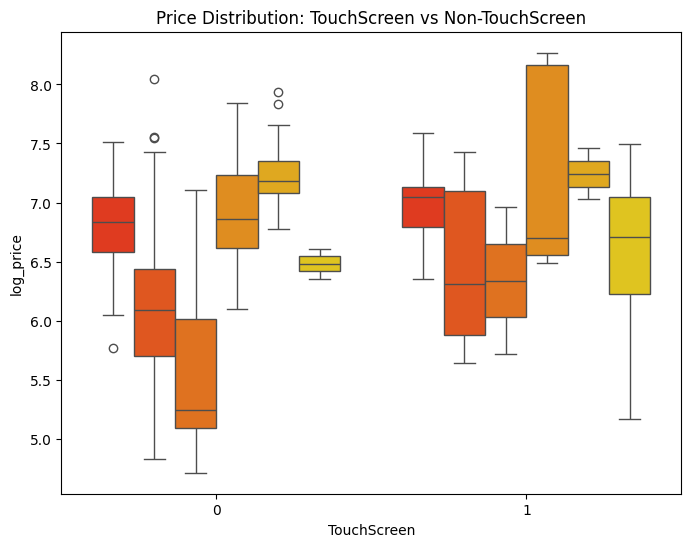

This boxplot compares prices of laptops with and without touchscreens.


In [29]:
# TouchScreen vs Price
plt.figure(figsize=(8, 6))
sns.boxplot(x='TouchScreen', y='log_price', hue='TypeName', data=df, palette='autumn', legend=False)
plt.title('Price Distribution: TouchScreen vs Non-TouchScreen')
plt.show()
print("This boxplot compares prices of laptops with and without touchscreens.")

In [30]:
# Prepare data for modeling
X = df.drop(['Price', 'log_price'], axis=1)
y = df['log_price']

In [31]:
print("\nFinal features for modeling:")
print(X.columns)


Final features for modeling:
Index(['Company', 'TypeName', 'Ram', 'OpSys', 'Weight', 'PPI', 'TouchScreen',
       'IPS', 'CPU_brand', 'HDD', 'SSD', 'GPU_brand'],
      dtype='object')


In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Define the preprocessing steps
numeric_features = ['Ram', 'Weight', 'PPI', 'TouchScreen', 'IPS', 'HDD', 'SSD']
categorical_features = ['Company', 'TypeName', 'OpSys', 'CPU_brand', 'GPU_brand']

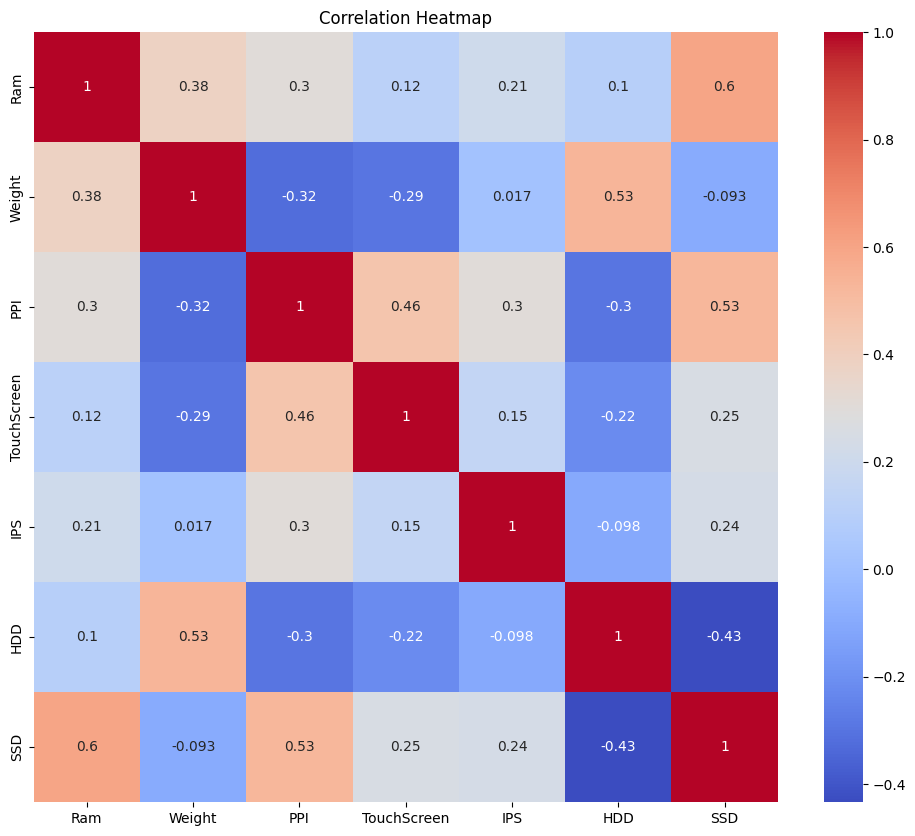

This heatmap shows correlations between numerical features. Strong correlations might indicate multicollinearity.


In [34]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
print("This heatmap shows correlations between numerical features. Strong correlations might indicate multicollinearity.")

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],remainder='passthrough')

In [36]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=0.001),
    'Decision Tree': DecisionTreeRegressor(max_depth=8),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=3, max_samples=0.5, max_features=0.75, max_depth=15)
}

In [37]:
# Train and evaluate models
results = {}

for name, model in models.items():
    # Create a pipeline with preprocessor and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store results
    results[name] = {'R2 Score': r2, 'MAE': mae}

    print(f"{name}:")
    print(f"R2 Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print()

Linear Regression:
R2 Score: 0.8270
Mean Absolute Error: 0.1949

Ridge Regression:
R2 Score: 0.8180
Mean Absolute Error: 0.1985

Lasso Regression:
R2 Score: 0.8212
Mean Absolute Error: 0.1977

Decision Tree:
R2 Score: 0.7985
Mean Absolute Error: 0.2029

Random Forest:
R2 Score: 0.8667
Mean Absolute Error: 0.1634



In [38]:
# Compare models
results_df = pd.DataFrame(results).T
print("Model Comparison:")
print(results_df)

Model Comparison:
                   R2 Score       MAE
Linear Regression  0.827002  0.194851
Ridge Regression   0.817974  0.198457
Lasso Regression   0.821229  0.197743
Decision Tree      0.798479  0.202892
Random Forest      0.866695  0.163447


In [39]:
# Identify the best model based on R2 score
best_model = results_df['R2 Score'].idxmax()
print(f"\nBest Model: {best_model}")


Best Model: Random Forest


In [40]:
# Train the best model on the entire dataset
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models[best_model])
])

best_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Ram', 'Weight', 'PPI',
                                                   'TouchScreen', 'IPS', 'HDD',
                                                   'SSD']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Company', 'TypeName',
                                                   'OpSys', 'CPU_brand',
                                                   'GPU_brand'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, max_features=0.75,
                                       max_samples=0.5, random_state=3))])

In [41]:
# Make predictions on the entire dataset
y_pred = best_pipeline.predict(X)

In [49]:
# Calculate metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
std_dev_errors = np.std(y - y_pred)

print(f"\nFinal Model Performance (trained on entire dataset):")
print(f"Best Model: {best_model}")
print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Standard Deviation of Errors: {std_dev_errors:.4f}")


Final Model Performance (trained on entire dataset):
Best Model: Random Forest
R2 Score: 0.9542
Mean Absolute Error: 0.1018
Root Mean Squared Error: 0.1334
Standard Deviation of Errors: 0.1334


In [43]:
# Calculate and print the mean percentage error
percentage_errors = np.abs((np.exp(y) - np.exp(y_pred)) / np.exp(y)) * 100
mpe = np.mean(percentage_errors)
print(f"Mean Percentage Error: {mpe:.2f}%")

Mean Percentage Error: 10.19%


In [44]:
# Save the trained model and its pipeline
dump(best_pipeline, '/content/drive/MyDrive/ML/laptop_price_predictor/best_model_pipeline.joblib')

['/content/drive/MyDrive/ML/laptop_price_predictor/best_model_pipeline.joblib']

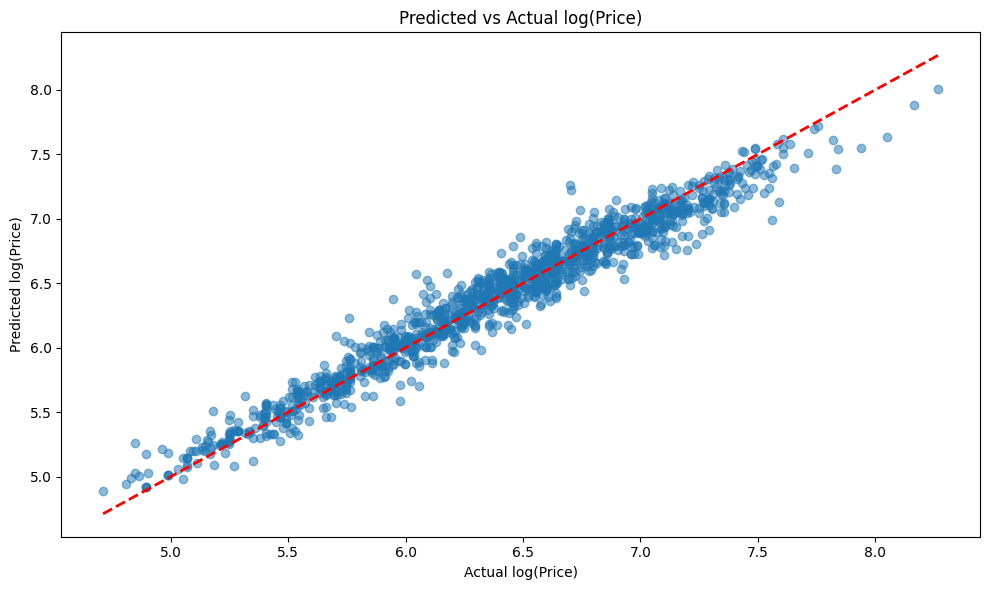

This scatter plot shows predicted vs actual log-transformed prices. Points closer to the red line indicate better predictions.


In [45]:
# Plot predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual log(Price)")
plt.ylabel("Predicted log(Price)")
plt.title("Predicted vs Actual log(Price)")
plt.tight_layout()
plt.show()
print("This scatter plot shows predicted vs actual log-transformed prices. Points closer to the red line indicate better predictions.")

In [46]:
# Save the training data to a CSV file
X.to_csv('/content/drive/MyDrive/ML/laptop_price_predictor/training_data.csv', index=False)

print("Best model and training data saved successfully.")

Best model and training data saved successfully.


In [47]:
# Example of using the saved model for prediction
new_laptop = pd.DataFrame({
    'Company': ['Dell'],
    'TypeName': ['Ultrabook'],
    'Ram': [16],
    'OpSys': ['Windows'],
    'Weight': [1.8],
    'PPI': [141],
    'TouchScreen': [1],
    'IPS': [1],
    'CPU_brand': ['Intel Core i7'],
    'HDD': [0],
    'SSD': [512],
    'GPU_brand': ['Nvidia']
})

In [53]:
# Calculate predicted price with error range
predicted_log_price = best_pipeline.predict(new_laptop)
predicted_price = np.exp(predicted_log_price)

# Calculate error margin
error_margin = std_dev_errors * 1.96  # 95% confidence interval
lower_bound = np.exp(predicted_log_price - error_margin)[0]
upper_bound = np.exp(predicted_log_price + error_margin)[0]

print(f"Predicted price for the new laptop: ${predicted_price[0]:.2f} ± ${predicted_price[0] * error_margin:.2f}")
print(f"95% Confidence Interval: ${lower_bound:.2f} - ${upper_bound:.2f}")

Predicted price for the new laptop: $1091.48 ± $285.34
95% Confidence Interval: $840.38 - $1417.59
